In [1]:
import numpy as np

In [2]:
import fair
from fair.unit_def import unit
import numpy as np

In [3]:
def calculate_alpha(cumulative_emissions,airborne_fraction,temperature,r0,rC,rT,g0,g1,iirf_max = 97.0*unit.year):
    iirf = r0 + rC * (cumulative_emissions-airborne_fraction) + rT * temperature
    iirf = np.abs(iirf)  # not sure I understand this - it should never be negative
    iirf = (iirf>iirf_max) * iirf_max + iirf * (iirf<iirf_max)
    alpha = g0 * np.sinh(iirf / g1)
    return alpha

def step_concentration(R_old,E,alpha,a,tau,PI_conc,emis2conc,dt=1):
    R_new = E * emis2conc * a * alpha * (tau/dt) * (1. - np.exp(-dt/(alpha*tau))) + R_old * np.exp(-dt/(alpha*tau))
    C = PI_conc + np.sum(R_new + R_old,axis=-1) / 2
    G_A = np.sum(R_new,axis=-1) / emis2conc
    return C,R_new,G_A

In [4]:
# still AR5-like IR models - can we tune?
a = np.array([0.217300, 0.224000, 0.282400, 0.276300])
tau = np.array([1000000.000000, 394.400000, 36.540000, 4.304000])*unit.year
r0 = 28.627296 * unit.year
rC = 0.019773 * unit.year / unit.Gt
rT = 4.334433 * unit.year / unit.K

In [5]:
r0

28.627296 <Unit('year')>

In [6]:
emis2conc = 0.468952 / unit.Gt * unit.ppm

In [7]:
emis2conc

0.468952 <Unit('parts_per_million / gigametric_ton')>

In [8]:
emissions = np.ones(100)*10*unit.Gt
C = np.zeros(100)*unit.ppm
G_A = np.zeros(100)*unit.Gt
alpha = np.zeros(100)

iirf_horizon=100 * unit.year
g1 = np.sum(a*tau * (1 - (1 + iirf_horizon/tau) * np.exp(-iirf_horizon/tau)), axis=-1)
g0 = 1/(np.sinh(np.sum(a*tau*(1 - np.exp(-iirf_horizon/tau)) , axis=-1)/g1))

In [9]:
alpha[0] = calculate_alpha(G=0*unit.Gt,G_A=0*unit.Gt,T=0*unit.K,r0=r0,rC=rC,rT=rT,g0=g0,g1=g1)
alpha[0]

0.12426187618147522

In [10]:
G = np.cumsum(emissions)
C[0],R,G_A[0] = step_concentration(
    R_old = np.zeros(a.shape)*unit.ppm,
    alpha=alpha[0],
    E=emissions[0],
    a=a,
    tau=tau,
    PI_conc=278*unit.ppm,
    emis2conc=emis2conc,
    dt=1*unit.year
)

In [11]:
C

array([279.91680765,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ]) <Unit('parts_per_million')>

In [12]:
R

array([1.0190286 , 1.03980804, 1.18862878, 0.58614988]) <Unit('parts_per_million')>

In [13]:
# forcing here
# temperature here

for t in np.arange(1,100):
    alpha[t] = calculate_alpha(G=G[t-1],G_A=G_A[t-1],T=0*unit.K,r0=r0,rC=rC,rT=rT,g0=g0,g1=g1)
    C[t],R,G_A[t] = step_concentration(
        R_old = R,
        alpha=alpha[t],
        E=emissions[t],
        a=a,
        tau=tau,
        PI_conc=278*unit.ppm,
        emis2conc=emis2conc,
        dt=1*unit.year
    )
    # forcing_here
    # temperature_here


In [14]:
import matplotlib.pyplot as pl

/nfs/b0110/Users/mencsm/miniconda3/envs/openscm-graft/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)


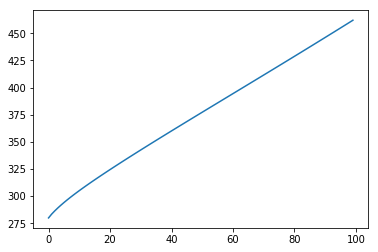

In [15]:
pl.plot(C)

In [16]:
G_A

array([  8.17485648,  14.7529535 ,  20.73454527,  26.33924518,
        31.65445586,  36.73646902,  41.6280468 ,  46.36292527,
        50.96795862,  55.46460221,  59.87005285,  64.19814412,
        68.46005091,  72.664844  ,  76.81992625,  80.93137584,
        85.00421643,  89.0426299 ,  93.05012427,  97.02966622,
       100.98378598, 104.91466038, 108.82417893, 112.71399625,
       116.58557402, 120.44021447, 124.27908726, 128.10325109,
       131.91367116, 135.71123328, 139.49675535, 143.27099673,
       147.03466595, 150.78842697, 154.5329045 , 158.26868826,
       161.99633669, 165.71637998, 169.4293227 , 173.13564596,
       176.83580936, 180.53025262, 184.219397  , 187.90364653,
       191.58338917, 195.25899776, 198.93083089, 202.5992337 ,
       206.26453861, 209.92706596, 213.58712459, 217.24501245,
       220.90101702, 224.55541585, 228.208477  , 231.86045939,
       235.51161326, 239.16218048, 242.81239492, 246.46248275,
       250.11266279, 253.76314672, 257.41413947, 261.06583935,
       264.71843841, 268.37212262, 272.02707211, 275.68346138,
       279.34145953, 283.00123043, 286.66293291, 290.32672096,
       293.99274392, 297.66114657, 301.33206938, 305.0056486 ,
       308.68201644, 312.36130121, 316.04362741, 319.72911593,
       323.41788412, 327.11004593, 330.80571202, 334.50498988,
       338.20798392, 341.91479558, 345.62552345, 349.34026332,
       353.05910829, 356.78214888, 360.50947309, 364.24116647,
       367.97731223, 371.71799129, 375.46328237, 379.21326204,
       382.96800479, 386.72758312, 390.49206758, 394.26152681]) <Unit('gigametric_ton')>

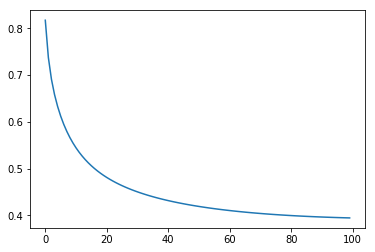

In [17]:
pl.plot(G_A/G)